# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [146]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

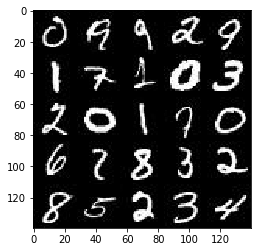

In [147]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

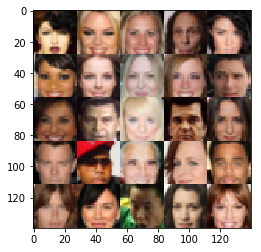

In [148]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [149]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [150]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return (real_input, z_input, learning_rate) 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [151]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    initializer=tf.contrib.layers.xavier_initializer()
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=initializer)
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32       
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=initializer)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate=0.9)
        # 7x7x64
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='valid', kernel_initializer=initializer)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=0.9)
        # 4x4x128
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=initializer)
        out = tf.sigmoid(logits)
        
        return (out, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [152]:
alpha = 0.1
def generator(z, out_channel_dim, is_train=True, reuse=False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    initializer=tf.contrib.layers.xavier_initializer()
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 2*2*512, kernel_initializer=initializer)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 2x2x512
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='valid', kernel_initializer=initializer)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate=0.9)
        # 7x7x256
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', kernel_initializer=initializer)
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=0.9)
        # 14x14x128
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=initializer)
        # 28x28x3     
        out = tf.tanh(logits)      
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [153]:
import numpy as np
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_fake = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(input_fake, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels = tf.ones_like(d_logits_fake) * np.random.uniform(0.8, 1.0)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels = tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels = tf.ones_like(d_logits_real) * np.random.uniform(0.8, 1.0)))
    d_loss = d_loss_real + d_loss_fake
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [154]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')] 
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return (d_train_op, g_train_op)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [155]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, reuse=True),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [156]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_op, g_op = model_opt(d_loss, g_loss, lr, beta1)
    
    show_every = 100
    print_every = 10
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                _ = sess.run(d_op, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_op, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),"Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[-1], data_image_mode)
                 
        show_generator_output(sess, batch_size, input_z, data_shape[-1], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 0.1846
Epoch 1/2... Discriminator Loss: 1.0920... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 0.4032... Generator Loss: 5.3963
Epoch 1/2... Discriminator Loss: -0.4049... Generator Loss: 2.7383
Epoch 1/2... Discriminator Loss: 1.8480... Generator Loss: -0.3604
Epoch 1/2... Discriminator Loss: -0.0943... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 0.1823... Generator Loss: 9.6369
Epoch 1/2... Discriminator Loss: 2.3202... Generator Loss: -0.3989
Epoch 1/2... Discriminator Loss: 0.3449... Generator Loss: -0.0200
Epoch 1/2... Discriminator Loss: 0.0154... Generator Loss: 0.6526


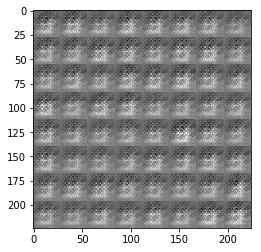

Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: -0.0350
Epoch 1/2... Discriminator Loss: 0.3990... Generator Loss: 1.3722
Epoch 1/2... Discriminator Loss: -0.1735... Generator Loss: 3.7966
Epoch 1/2... Discriminator Loss: 0.1386... Generator Loss: 0.3567
Epoch 1/2... Discriminator Loss: -0.5141... Generator Loss: 2.1483
Epoch 1/2... Discriminator Loss: -0.4464... Generator Loss: 0.8078
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 0.0213
Epoch 1/2... Discriminator Loss: -0.5070... Generator Loss: 3.7013
Epoch 1/2... Discriminator Loss: -0.1859... Generator Loss: 3.5211
Epoch 1/2... Discriminator Loss: 0.3612... Generator Loss: 1.6832


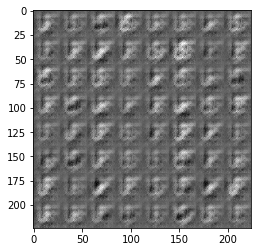

Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 0.3182
Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 0.1943
Epoch 1/2... Discriminator Loss: 0.1915... Generator Loss: 0.7144
Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: -0.0323
Epoch 1/2... Discriminator Loss: 0.9503... Generator Loss: 0.2046
Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 0.1118
Epoch 1/2... Discriminator Loss: 0.8636... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 0.0480
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 0.0437
Epoch 1/2... Discriminator Loss: 0.5768... Generator Loss: 0.3243


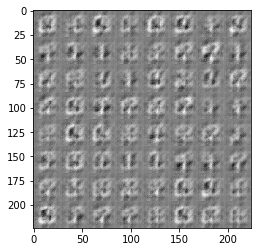

Epoch 1/2... Discriminator Loss: 0.6320... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 0.4701... Generator Loss: 2.0584
Epoch 1/2... Discriminator Loss: 0.8457... Generator Loss: 1.8315
Epoch 1/2... Discriminator Loss: 0.1883... Generator Loss: 1.7631
Epoch 1/2... Discriminator Loss: 1.0028... Generator Loss: 2.0248
Epoch 1/2... Discriminator Loss: 0.6954... Generator Loss: 0.2036
Epoch 1/2... Discriminator Loss: 0.4725... Generator Loss: 0.2444
Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 0.1887
Epoch 1/2... Discriminator Loss: 0.6427... Generator Loss: 0.4008
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: -0.0906


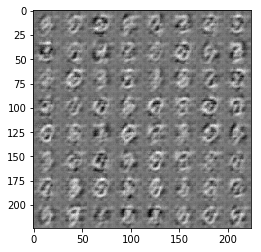

Epoch 1/2... Discriminator Loss: 0.6684... Generator Loss: 0.1604
Epoch 1/2... Discriminator Loss: 0.6983... Generator Loss: 0.1184
Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 0.0008
Epoch 1/2... Discriminator Loss: 0.8357... Generator Loss: 0.0286
Epoch 1/2... Discriminator Loss: 0.8063... Generator Loss: 0.0334
Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: -0.0851
Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 0.4842
Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 0.1159
Epoch 1/2... Discriminator Loss: 0.7950... Generator Loss: 0.1074
Epoch 1/2... Discriminator Loss: 0.6409... Generator Loss: 0.3057


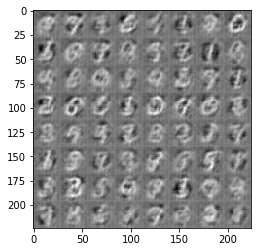

Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 2.5034
Epoch 1/2... Discriminator Loss: 0.4850... Generator Loss: 1.8339
Epoch 1/2... Discriminator Loss: 0.5451... Generator Loss: 1.4016
Epoch 1/2... Discriminator Loss: 0.4207... Generator Loss: 1.6159
Epoch 1/2... Discriminator Loss: 0.8169... Generator Loss: 0.1463
Epoch 1/2... Discriminator Loss: 1.3430... Generator Loss: -0.1832
Epoch 1/2... Discriminator Loss: 0.6984... Generator Loss: 0.2906
Epoch 1/2... Discriminator Loss: 0.5245... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 1.6128... Generator Loss: -0.3027
Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 0.0444


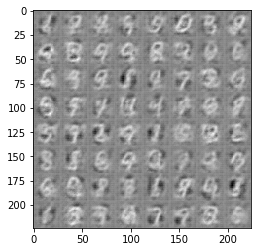

Epoch 1/2... Discriminator Loss: 0.6882... Generator Loss: 0.2758
Epoch 1/2... Discriminator Loss: 0.5985... Generator Loss: 1.1808
Epoch 1/2... Discriminator Loss: 0.4355... Generator Loss: 1.6252
Epoch 1/2... Discriminator Loss: 0.5576... Generator Loss: 1.2849
Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 1.4177
Epoch 1/2... Discriminator Loss: 0.6399... Generator Loss: 1.3979
Epoch 1/2... Discriminator Loss: 0.5699... Generator Loss: 1.1130
Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 1.4741
Epoch 1/2... Discriminator Loss: 0.5927... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 0.7776... Generator Loss: 1.6390


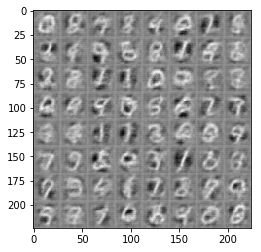

Epoch 1/2... Discriminator Loss: 0.4604... Generator Loss: 1.1295
Epoch 1/2... Discriminator Loss: 0.8086... Generator Loss: 1.4695
Epoch 1/2... Discriminator Loss: 0.7438... Generator Loss: 1.5195
Epoch 1/2... Discriminator Loss: 0.8537... Generator Loss: 1.6279
Epoch 1/2... Discriminator Loss: 0.6444... Generator Loss: 0.6405
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: -0.0434
Epoch 1/2... Discriminator Loss: 0.4907... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 0.6774... Generator Loss: 0.9792
Epoch 1/2... Discriminator Loss: 0.6266... Generator Loss: 1.1458
Epoch 1/2... Discriminator Loss: 0.7849... Generator Loss: 1.2463


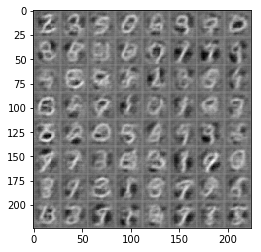

Epoch 1/2... Discriminator Loss: 0.5177... Generator Loss: 0.9159
Epoch 1/2... Discriminator Loss: 0.6713... Generator Loss: 1.2784
Epoch 1/2... Discriminator Loss: 0.6203... Generator Loss: 1.0877
Epoch 1/2... Discriminator Loss: 0.7261... Generator Loss: 0.6275
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 0.3585
Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: -0.0248
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: -0.0021
Epoch 1/2... Discriminator Loss: 0.7544... Generator Loss: 0.1933
Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: -0.1136
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: -0.1281


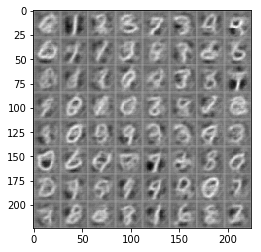

Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 0.0058
Epoch 1/2... Discriminator Loss: 0.7144... Generator Loss: 0.1789
Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 0.0262
Epoch 2/2... Discriminator Loss: 0.8063... Generator Loss: 0.0535
Epoch 2/2... Discriminator Loss: 0.8185... Generator Loss: 0.1085
Epoch 2/2... Discriminator Loss: 0.9534... Generator Loss: -0.0257
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 0.0513
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: -0.1409
Epoch 2/2... Discriminator Loss: 1.6721... Generator Loss: -0.3294
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: -0.0117


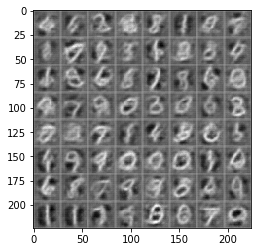

Epoch 2/2... Discriminator Loss: 0.5508... Generator Loss: 0.2842
Epoch 2/2... Discriminator Loss: 0.4246... Generator Loss: 1.4869
Epoch 2/2... Discriminator Loss: 0.6266... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 0.5791... Generator Loss: 1.1254
Epoch 2/2... Discriminator Loss: 0.7783... Generator Loss: 1.8322
Epoch 2/2... Discriminator Loss: 0.5543... Generator Loss: 1.2156
Epoch 2/2... Discriminator Loss: 0.5377... Generator Loss: 1.0948
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.5956
Epoch 2/2... Discriminator Loss: 0.4466... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 0.6109... Generator Loss: 1.8947


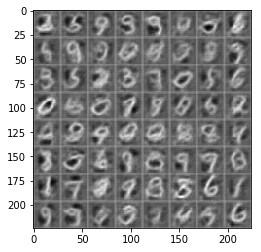

Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: -0.1610
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 0.0912
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: -0.1002
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 0.1055
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: -0.0072
Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: -0.1253
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 0.0488
Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: -0.0614
Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 0.2676
Epoch 2/2... Discriminator Loss: 1.8151... Generator Loss: -0.4157


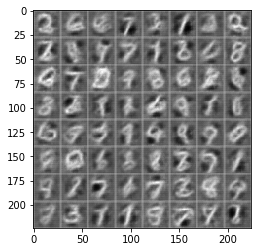

Epoch 2/2... Discriminator Loss: 0.4071... Generator Loss: 0.6611
Epoch 2/2... Discriminator Loss: 0.4997... Generator Loss: 0.5606
Epoch 2/2... Discriminator Loss: 1.1460... Generator Loss: -0.0892
Epoch 2/2... Discriminator Loss: 1.4892... Generator Loss: -0.3011
Epoch 2/2... Discriminator Loss: 0.6011... Generator Loss: 1.8081
Epoch 2/2... Discriminator Loss: 0.5287... Generator Loss: 1.7704
Epoch 2/2... Discriminator Loss: 0.4318... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 5.0199... Generator Loss: -1.0853
Epoch 2/2... Discriminator Loss: 0.2358... Generator Loss: 0.8672
Epoch 2/2... Discriminator Loss: 0.5024... Generator Loss: 0.4324


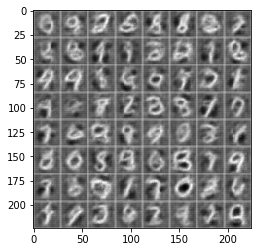

Epoch 2/2... Discriminator Loss: 0.8678... Generator Loss: 0.0058
Epoch 2/2... Discriminator Loss: 1.0576... Generator Loss: -0.0991
Epoch 2/2... Discriminator Loss: 0.3874... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 0.0390
Epoch 2/2... Discriminator Loss: 0.5543... Generator Loss: 1.8675
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: -0.0458
Epoch 2/2... Discriminator Loss: 0.4362... Generator Loss: 0.6893
Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 0.0244
Epoch 2/2... Discriminator Loss: 1.9988... Generator Loss: -0.4433
Epoch 2/2... Discriminator Loss: 0.5772... Generator Loss: 0.1694


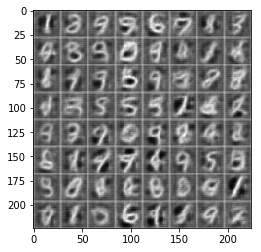

Epoch 2/2... Discriminator Loss: 0.2393... Generator Loss: 0.8622
Epoch 2/2... Discriminator Loss: 1.4591... Generator Loss: -0.3725
Epoch 2/2... Discriminator Loss: 0.9861... Generator Loss: -0.0430
Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 1.4849... Generator Loss: -0.2784
Epoch 2/2... Discriminator Loss: 3.0463... Generator Loss: -0.7186
Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 0.4454
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: -0.0613
Epoch 2/2... Discriminator Loss: 0.6985... Generator Loss: 0.1232
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 0.1839


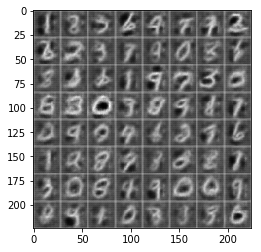

Epoch 2/2... Discriminator Loss: 0.7379... Generator Loss: 1.2898
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: -0.2758
Epoch 2/2... Discriminator Loss: 0.9052... Generator Loss: -0.0134
Epoch 2/2... Discriminator Loss: 0.4146... Generator Loss: 1.9961
Epoch 2/2... Discriminator Loss: 0.6792... Generator Loss: 0.1027
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 2.3370
Epoch 2/2... Discriminator Loss: 0.4946... Generator Loss: 0.3547
Epoch 2/2... Discriminator Loss: 0.3195... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 0.1916... Generator Loss: 1.7970
Epoch 2/2... Discriminator Loss: 0.1806... Generator Loss: 0.8598


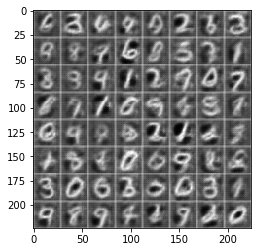

Epoch 2/2... Discriminator Loss: 1.7357... Generator Loss: -0.4090
Epoch 2/2... Discriminator Loss: 0.3478... Generator Loss: 0.9811
Epoch 2/2... Discriminator Loss: 0.3866... Generator Loss: 0.4366
Epoch 2/2... Discriminator Loss: 0.1039... Generator Loss: 1.8930
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: -0.0846
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: -0.0064
Epoch 2/2... Discriminator Loss: 0.8709... Generator Loss: -0.1000
Epoch 2/2... Discriminator Loss: 1.1662... Generator Loss: -0.2612
Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: -0.3205
Epoch 2/2... Discriminator Loss: 0.4875... Generator Loss: 0.5445


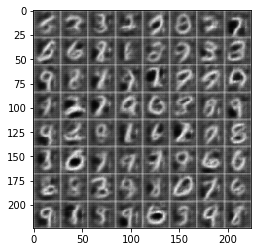

Epoch 2/2... Discriminator Loss: 0.4703... Generator Loss: 0.3253
Epoch 2/2... Discriminator Loss: 0.3856... Generator Loss: 0.4813
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 0.2755... Generator Loss: 1.9935
Epoch 2/2... Discriminator Loss: 0.3353... Generator Loss: 0.2576
Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 0.0045
Epoch 2/2... Discriminator Loss: 2.0336... Generator Loss: -0.5097
Epoch 2/2... Discriminator Loss: 0.7270... Generator Loss: 0.0176
Epoch 2/2... Discriminator Loss: 0.2868... Generator Loss: 1.0016
Epoch 2/2... Discriminator Loss: 0.2787... Generator Loss: 0.4991


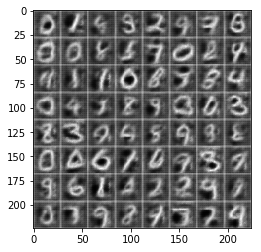

Epoch 2/2... Discriminator Loss: 0.6014... Generator Loss: 0.0941
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: -0.1580
Epoch 2/2... Discriminator Loss: 0.2767... Generator Loss: 0.8673
Epoch 2/2... Discriminator Loss: 0.3042... Generator Loss: 0.3048
Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 0.2458
Epoch 2/2... Discriminator Loss: 0.2357... Generator Loss: 3.0167
Epoch 2/2... Discriminator Loss: 0.5705... Generator Loss: 0.7280


In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1770... Generator Loss: 0.3712
Epoch 1/1... Discriminator Loss: 2.3619... Generator Loss: 3.7763
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 1.9864
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 2.4173
Epoch 1/1... Discriminator Loss: 1.6669... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 2.7805
Epoch 1/1... Discriminator Loss: 0.7664... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 0.7940... Generator Loss: 2.1765


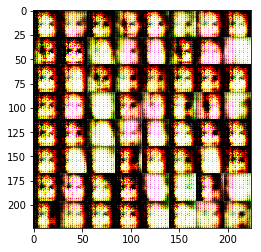

Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 3.7408
Epoch 1/1... Discriminator Loss: 3.7259... Generator Loss: 5.5949
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 2.2731... Generator Loss: 4.0683
Epoch 1/1... Discriminator Loss: 1.6918... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.4899
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.5325


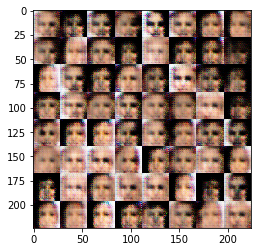

Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.3170
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 0.8053


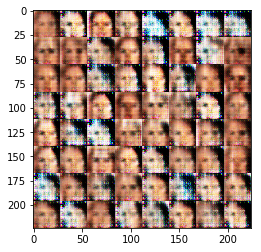

Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.6551... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 2.8614... Generator Loss: 4.3030
Epoch 1/1... Discriminator Loss: 1.9132... Generator Loss: 2.3876
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 2.1473
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.7523... Generator Loss: 1.6137


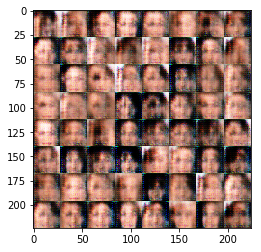

Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.7139... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.1939
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.4530
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.6085


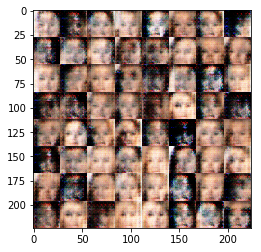

Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.9290
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.6725... Generator Loss: 0.4405
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 1.4632
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.9881... Generator Loss: 0.4003
Epoch 1/1... Discriminator Loss: 2.0118... Generator Loss: 0.4003
Epoch 1/1... Discriminator Loss: 1.8337... Generator Loss: 3.2617


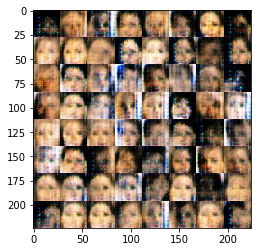

Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.5853
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.6043
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.9177... Generator Loss: 0.4050
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8241


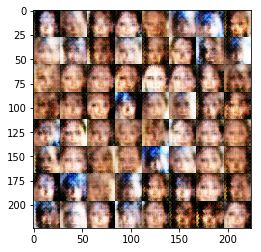

Epoch 1/1... Discriminator Loss: 1.7387... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.7360... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.9241
Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.4727
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 2.4513
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.5061


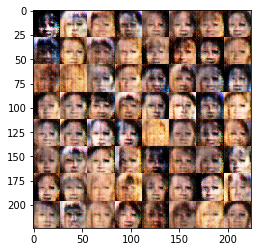

Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.0271


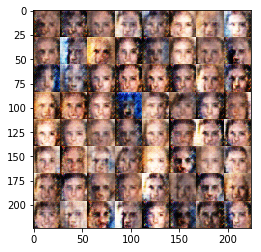

Epoch 1/1... Discriminator Loss: 1.6294... Generator Loss: 2.5263
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.3224
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 2.4209
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.2898


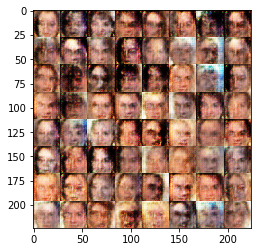

Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.3467
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.3724
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.5473


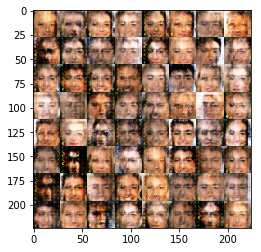

Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 1.6147
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.1302


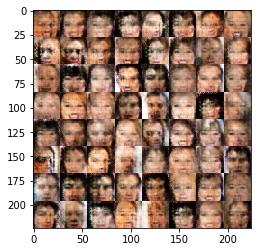

Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 1.7129
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 2.1620
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 1.6746


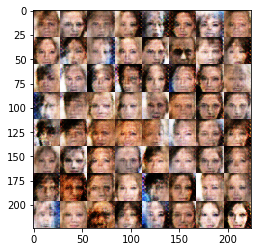

Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 1.5772
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.2012
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.0001


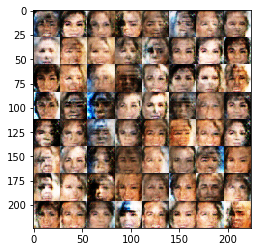

Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.7364... Generator Loss: 0.4226
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.7372


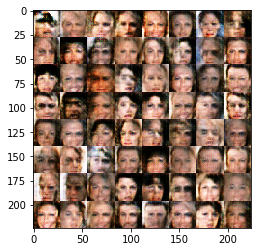

Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 1.2934
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.3313
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 0.8788


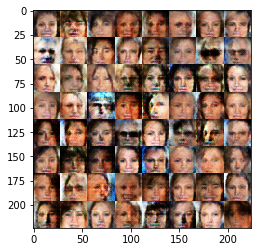

Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.5596
Epoch 1/1... Discriminator Loss: 1.9105... Generator Loss: 0.4064
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.6262


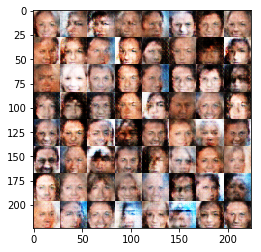

Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.6079... Generator Loss: 0.4436
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.1837
Epoch 1/1... Discriminator Loss: 2.5333... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.5073
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.1999
Epoch 1/1... Discriminator Loss: 1.6744... Generator Loss: 0.4562
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.4684


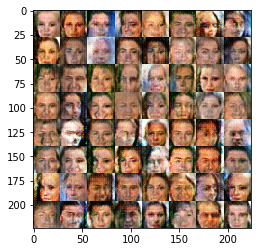

Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.8393
Epoch 1/1... Discriminator Loss: 2.2449... Generator Loss: 3.4591
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.9255


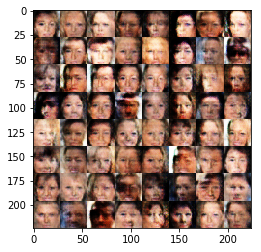

Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.8857... Generator Loss: 2.4564
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.5599... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.1750


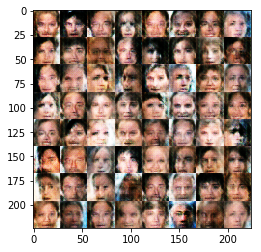

Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.4765
Epoch 1/1... Discriminator Loss: 1.7837... Generator Loss: 0.4385
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.6760


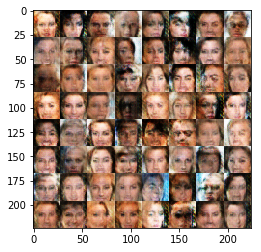

Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 1.5508
Epoch 1/1... Discriminator Loss: 2.0281... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.3731


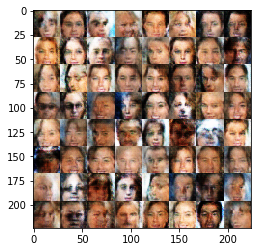

Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.5582
Epoch 1/1... Discriminator Loss: 1.8123... Generator Loss: 0.4112
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 2.2765... Generator Loss: 3.1105
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.6736


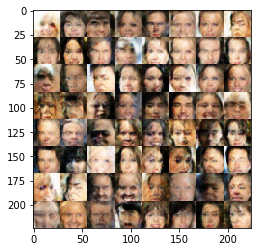

Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.4590
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.4830
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.8663


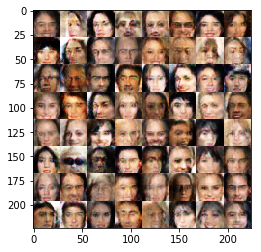

Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.6871... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.1473


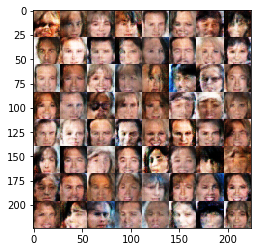

Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 2.1221
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 2.0512
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 0.8344


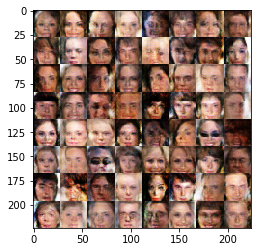

Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.7298... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.0246


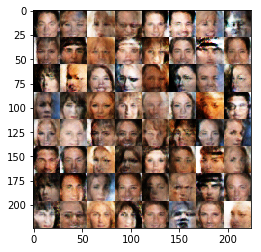

Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 1.8461
Epoch 1/1... Discriminator Loss: 1.8298... Generator Loss: 0.4153
Epoch 1/1... Discriminator Loss: 1.6323... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.5202


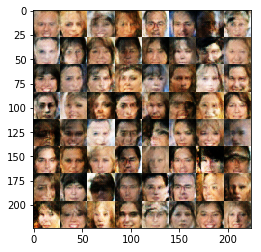

Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.2214
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.7351


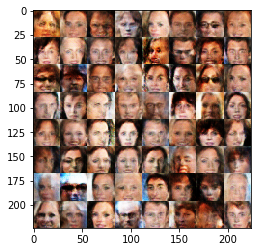

Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 1.7152
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.7275


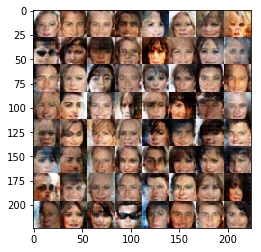

Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.2201
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.7988... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.6034... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.9407


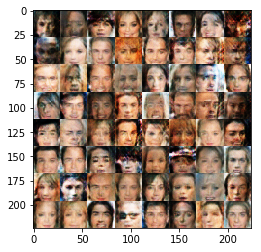

Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 1.2186
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 0.9533


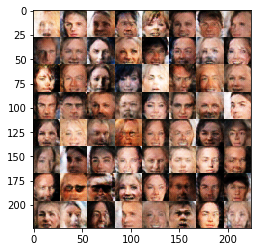

In [158]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.